In [2]:
import os
import torch
import pandas as pd
import matplotlib.pyplot as plt
from torch import nn, cuda
from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
# df_men_train =pd.read_csv( r"C:\Users\busse\Bachelorarbeit\CICD-Pipeline-Gender-Recognition\model\excel_sheets\git_image_paths_val_men.csv")
# df_men_train["Images"] = df_men_train["Images"].str.replace("C:/Users/busse/Bachelorarbeit/CICD-Pipeline-Gender-Recognition/", " ")
# df_men_train.to_csv(r"C:\Users\busse\Bachelorarbeit\CICD-Pipeline-Gender-Recognition\model\excel_sheets\git_image_paths_val_men.csv")


In [14]:


epochs = 1
batch_size = 64

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
# img_dir_train ='C:/Users/busse/Bachelorarbeit/CICD-Pipeline-Gender-Recognition/data/train'
# img_dir_val = 'C:/Users/busse/Bachelorarbeit/CICD-Pipeline-Gender-Recognition/data/val'
# train_dataset = datasets.ImageFolder(root=img_dir_train,transform=transform)
# test_dataset = datasets.ImageFolder(root= img_dir_val,transform=transform)
# Apply the transformation to your dataset
train_dataset = datasets.ImageFolder(root='data/train',transform=transform)
test_dataset = datasets.ImageFolder(root= 'data/val',transform=transform)
df_men_train = pd.read_csv("model/excel_sheets/git_image_paths_men.csv")
df_women_train = pd.read_csv("model/excel_sheets/git_image_paths_women.csv")
df_women_test = pd.read_csv("model/excel_sheets/git_image_paths_val_women.csv")
df_men_test = pd.read_csv("model/excel_sheets/git_image_paths_val_men.csv")
merged_df_train = pd.concat([df_men_train, df_women_train], ignore_index=True)
merged_df_test = pd.concat([df_men_test, df_women_test], ignore_index=True)
merged_df_test.to_csv("model/git_merged_df_test.csv")
merged_df_train.to_csv("model/git_merged_df_train.csv")

In [12]:

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 1])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 2]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label


train_data = CustomImageDataset(annotations_file='model/git_merged_df_train.csv',img_dir='data/train')
test_data =  CustomImageDataset(annotations_file='model/git_merged_df_test.csv',img_dir='data/val')

# train_data = CustomImageDataset(annotations_file='C:/Users/busse/Bachelorarbeit/CICD-Pipeline-Gender-Recognition/model/csv_sheets/merged_df_train.csv',img_dir='C:/Users/busse/Bachelorarbeit/CICD-Pipeline-Gender-Recognition/data/train')
# test_data =  CustomImageDataset(annotations_file='C:/Users/busse/Bachelorarbeit/CICD-Pipeline-Gender-Recognition/model/csv_sheets/merged_df_test.csv',img_dir='C:/Users/busse/Bachelorarbeit/CICD-Pipeline-Gender-Recognition/data/val')

In [15]:


train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
 


In [ ]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
img = train_features[0].permute(1, 2, 0)
plt.imshow(img, cmap="gray")

In [16]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Erste Convolutional Layer. Nimmt 3 Eingangskanäle (RGB), gibt 6 Kanäle aus, mit einer Kernelgröße von 5
        self.conv1 = nn.Conv2d(3, 6, 5)  
        # Max-Pooling-Layer mit einem quadratischen Fenster der Kernelgröße=4, Schrittgröße=4
        self.pool = nn.MaxPool2d(4, 4)  
        # Zweite Convolutional Layer. Nimmt 6 Eingangskanäle (von der vorherigen Schicht), gibt 16 Kanäle aus, mit einer Kernelgröße von 5
        self.conv2 = nn.Conv2d(6, 16, 5)
        # Max-Pooling-Layer mit einem quadratischen Fenster der Kernelgröße=2, Schrittgröße=2
        self.pool = nn.MaxPool2d(2,2) 
        # Erste vollständig verbundene Schicht. Nimmt einen abgeflachten Vektor der Größe 33456 auf, gibt einen Vektor der Größe 120 aus
        self.fc1 = nn.Linear(33456 , 120) 
        # Zweite vollständig verbundene Schicht. Nimmt einen Vektor der Größe 120 auf, gibt einen Vektor der Größe 84 aus
        self.fc2 = nn.Linear(120, 84)
        # Dritte vollständig verbundene Schicht. Nimmt einen Vektor der Größe 84 auf, gibt einen Vektor der Größe 2 aus
        self.fc3 = nn.Linear(84, 2) 

    def forward(self, x):
        # Anwendung der ersten Conv-Schicht, dann ReLU-Aktivierungsfunktion, dann Max-Pooling
        x = self.pool(F.relu(self.conv1(x)))
        # Anwendung der zweiten Conv-Schicht, dann ReLU-Aktivierungsfunktion, dann Max-Pooling
        x = self.pool(F.relu(self.conv2(x)))
        # Abflachen des Tensorausgangs von den Conv-Schichten
        x = x.view(x.size(0), -1) 
        # Anwendung der ersten vollständig verbundenen Schicht, dann ReLU-Aktivierungsfunktion
        x = F.relu(self.fc1(x))  
        # Anwendung der zweiten vollständig verbundenen Schicht, dann ReLU-Aktivierungsfunktion
        x = F.relu(self.fc2(x)) 
        # Anwendung der dritten vollständig verbundenen Schicht
        x = self.fc3(x)  
        return x

In [ ]:
import torch.optim as optim
from tqdm import tqdm

# Instantiate the model, loss function and optimizer
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Assume `val_dataloader` is your DataLoader for the validation set
# for epoch in range(epochs):  # loop over the dataset multiple times
#     running_loss = 0.0
#     for i, data in enumerate(tqdm(train_dataloader), 0):
#         # get the inputs; data is a list of [inputs, labels]
#         inputs, labels = data

#         # zero the parameter gradients
#         optimizer.zero_grad()

#         # forward + backward + optimize
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()  
         

#         # Trainingsverlauf ausgeben
#         running_loss += loss.item()

#         #Alle 10 Batches wird der Loss ausgegeben
#         if i % 10 == 9:    
#             # Berechnung der Accuracy
#             correct = 0
#             total = 0
#             with torch.no_grad():
#                 for val_data in test_dataloader:
#                     val_images, val_labels = val_data
#                     val_outputs = model(val_images)
#                     _, predicted = torch.max(val_outputs.data, 1)
#                     total += val_labels.size(0)
#                     correct += (predicted == val_labels).sum().item()
#             val_accuracy = correct / total

#             print(f'Epoch: {epoch + 1}, Batch: {i + 1}, Loss: {running_loss / 10}, Validation Accuracy: {val_accuracy * 100}%')
#             running_loss = 0.0

# print('Finished Training')


for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(tqdm(train_dataloader), 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()  

        # Trainingsverlauf ausgeben
        running_loss += loss.item()

        #Alle 10 Batches wird der Loss ausgegeben
        if i % 10 == 9:    
            # Berechnung der Accuracy
            correct = 0
            total = 0
            with torch.no_grad():
                for val_data in test_dataloader:
                    val_images, val_labels = val_data
                    val_outputs = model(val_images)
                    _, predicted = torch.max(val_outputs.data, 1)
                    total += val_labels.size(0)
                    correct += (predicted == val_labels).sum().item()
            val_accuracy = correct / total

            print(f'Epoch: {epoch + 1}, Batch: {i + 1}, Loss: {running_loss / 10}, Validation Accuracy: {val_accuracy * 100}%')
            running_loss = 0.0

            # Wenn die Validation Accuracy 95% erreicht, wird das Training beendet
            if val_accuracy >= 0.95:
                print('Early stopping, validation accuracy reached 95%')
                break

print('Finished Training')

In [ ]:
torch.save(model.state_dict(), f'model/model{batch_size}' + '-' + f'{epochs}' + '.pth')

In [18]:
# model_path = 'C:/Users/busse/Bachelorarbeit/CICD-Pipeline-Gender-Recognition/model/model64.pth'
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model = SimpleCNN()
# # model.load_state_dict(torch.load(f'model/model{batch_size}' + '-' + f'{epochs}' + '.pth'))
# model.load_state_dict(torch.load(model_path))

# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# for inputs, _ in test_loader:
#     inputs = inputs.to(device) 
#     output = model(inputs)
#     probabilities = torch.nn.functional.softmax(output, dim=1)
#     predictions = torch.argmax(probabilities, dim=1)
#     predictions_list = predictions.cpu().numpy().tolist()
#     print(predictions_list)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0

In [19]:
# import torch
# from torch.utils.data import DataLoader


# # Load the model
# model = SimpleCNN()
# # model.load_state_dict(torch.load(f'model/model{batch_size}' + '-' + f'{epochs}' + '.pth'))
# model.load_state_dict(torch.load(model_path))
# # Assume `test_dataset` is your ImageFolder dataset
# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# # Use the model to make predictions and calculate accuracy
# correct = 0
# total = 0

# for inputs, labels in test_loader:
#     inputs = inputs.to(device)
#     labels = labels.to(device)
    
#     # Forward pass
#     outputs = model(inputs)
#     _, predicted = torch.max(outputs.data, 1)
    
#     # Update total and correct counts
#     total += labels.size(0)
#     correct += (predicted == labels).sum().item()

# # Calculate accuracy
# accuracy = correct / total
# print('Accuracy of the model on the test images: {}%'.format(100 * accuracy))

Accuracy of the model on the test images: 83.5%


In [20]:
# # Assuming `model` is your trained model and `test_loader` is your test data loader
# model.eval()  # Set the model to evaluation mode
# predictions = []
# true_labels = []
# with torch.no_grad():
#     for inputs, labels in test_loader:
#         outputs = model(inputs)
#         _, predicted = torch.max(outputs, 1)
#         predictions.extend(predicted)
#         true_labels.extend(labels)


# # Convert the lists to numpy arrays
# predictions = np.array(predictions)
# true_labels = np.array(true_labels)

# # Calculate the metrics
# accuracy = accuracy_score(true_labels, predictions)
# precision = precision_score(true_labels, predictions, average='weighted')
# recall = recall_score(true_labels, predictions, average='weighted')
# f1 = f1_score(true_labels, predictions, average='weighted')

# print(f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1-score: {f1}')

Accuracy: 0.835, Precision: 0.8389535542568519, Recall: 0.835, F1-score: 0.8345174528926349


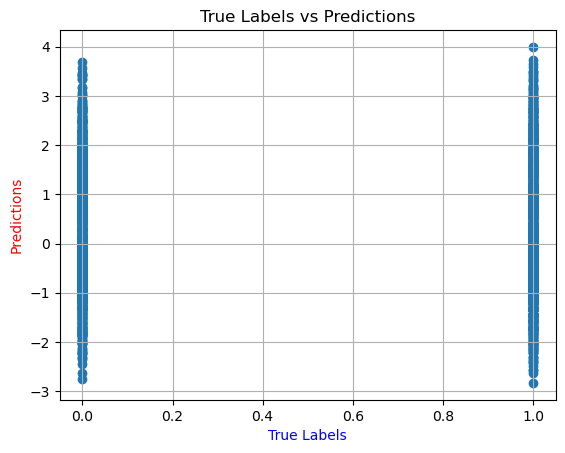

In [81]:
# import matplotlib.pyplot as plt
# import numpy as np

# model.eval()  # Set the model to evaluation mode

# predictions = []
# labels_list = []
# with torch.no_grad():
#     for data, labels in test_loader:
#         outputs = model(data)
#         # Flatten the outputs and convert to numpy array
#         predictions.extend(outputs.view(-1).cpu().numpy())
#         labels_list.extend(labels.cpu().numpy())

# # Flatten the arrays
# predictions = np.array(predictions).ravel()
# labels_list = np.array(labels_list).ravel()

# # Ensure both arrays have the same length
# min_length = min(len(predictions), len(labels_list))
# predictions = predictions[:min_length]
# labels_list = labels_list[:min_length]

# predictions = np.array(predictions).ravel()
# labels_list = np.array(labels_list).ravel()

# # Plot true labels against predictions
# # plt.scatter(labels_list,predictions)
# plt.scatter(labels_list,predictions)
# plt.grid(True)
# plt.xlabel('True Labels')
# plt.ylabel('Predictions')
# plt.xlabel('True Labels',color='blue')
# plt.ylabel('Predictions',color='red')
# plt.title('True Labels vs Predictions')
# plt.savefig("plot_truelabelVSpredictions.jpg",dpi=300)
# plt.show()